In [1]:
import sys
sys.path.insert(0, '..')
from dhmc.dhmc_sampler import DHMCSampler
from other_samplers.mcmc_diagnostic import batch_ess
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

### Load the (cleaned) SECOM data.

In [2]:
y = np.load('../data_and_posterior/secom_outcome.npy')
X = np.load('../data_and_posterior/secom_design_matrix.npy') # With intercept.
n_param = X.shape[1]
n_disc = n_param # No conditional density is smooth.

### Define functions to compute the posterior density.

In [3]:
def f(theta, req_grad=True):
    """
    Computes the log posterior density and its gradient. 
    
    Params:
    ------
    theta : ndarray
    req_grad : bool
        If True, returns the gradient along with the log density.
    
    Returns:
    -------
    logp : float
    grad : ndarray
    aux : Any
        Any computed quantities that can be re-used by the 
        subsequent calls to the function 'f_updated' to save on
        computation.
    """
    
    logp = 0
    grad = np.zeros(len(y))
    
    # Contribution from the prior.
    logp += - np.sum(theta ** 2) / 2
    
    # Contribution from the likelihood.
    y_hat = np.dot(X, theta)
    loglik = np.count_nonzero(y * y_hat > 0)
    logp += loglik
    
    aux = (loglik, y_hat)
    return logp, np.zeros(len(theta)), aux

def f_update(theta, dtheta, j, aux):
    """
    Computes the difference in the log conditional density 
    along a given parameter index 'j'.
    
    Params:
    ------
    theta : ndarray
    dtheta : float
        Amount by which the j-th parameter is updated.
    j : int
        Index of the parameter to update.
    aux : Any
        Computed quantities from the most recent call to functions
        'f' or 'f_update' that can be re-used to save on computation.
    
    Returns:
    -------
    logp_diff : float
    aux_new : Any
    """
    
    loglik_prev, y_hat = aux
    y_hat = y_hat + X[:,j] * dtheta
    
    logp_diff = (theta[j] ** 2 - (theta[j] + dtheta) ** 2) / 2
    
    # Contribution from the likelihood.
    loglik = np.count_nonzero(y * y_hat > 0)
    logp_diff += loglik - loglik_prev
    
    aux_new = (loglik, y_hat)
    return logp_diff, aux_new

#### Initial state for MCMC.

In [4]:
intercept0 = np.log(np.mean(y == 1) / (1 - np.mean(y == 1)))
beta0 = np.zeros(X.shape[1])
beta0[0] = intercept0
theta0 = beta0

#### Test the gradient and updating function.

In [5]:
scale = np.ones(n_param)
dhmc = DHMCSampler(f, f_update, n_disc, n_param, scale)
dhmc.test_cont_grad(theta0, sd=.01, n_test=10);
_, theta, logp_fdiff, logp_diff = \
    dhmc.test_update(theta0, sd=10, n_test=100)

Test passed! The computed gradient seems to be correct.
Test passed! The logp differences agree.


### Run discontinuous HMC

In [6]:
seed = 1
n_burnin = 10 ** 2
n_sample = 10 ** 3
dt = .3 * np.array([.7, 1]) 
nstep = [20, 30] 
samples, logp_samples, accept_prob, nfevals_per_itr, time_elapsed = \
    dhmc.run_sampler(theta0, dt, nstep, n_burnin, n_sample, seed=seed)
    
dhmc_samples = samples[n_burnin:, :]

110 iterations have been completed.
220 iterations have been completed.
330 iterations have been completed.
440 iterations have been completed.
550 iterations have been completed.
660 iterations have been completed.
770 iterations have been completed.
880 iterations have been completed.
990 iterations have been completed.
1100 iterations have been completed.
The average path length of each DHMC iteration was 24.89.


### Compute ESS's and plot them.

In [7]:
ess_dhmc = batch_ess(dhmc_samples, normed=False)
index_sort = np.argsort(ess_dhmc)

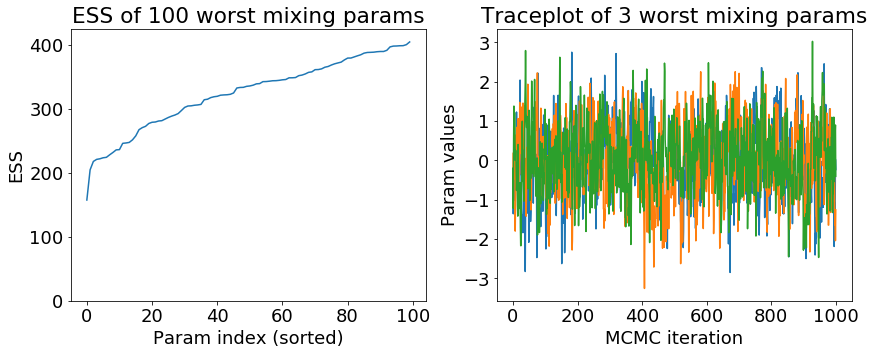

In [8]:
plt.figure(figsize=(14, 5))
plt.rcParams['font.size'] = 18

plt.subplot(1, 2, 1)
plt.plot(ess_dhmc[index_sort[:100]])
plt.ylabel('ESS')
plt.xlabel('Param index (sorted)')
plt.title('ESS of 100 worst mixing params')
plt.ylim(0, 1.05 * np.max(ess_dhmc[index_sort[:100]]))

plt.subplot(1, 2, 2)
plt.plot(dhmc_samples[:, index_sort[:3]])
plt.ylabel('Param values')
plt.xlabel('MCMC iteration')
plt.title('Traceplot of 3 worst mixing params')

plt.show()

### Run Metropolis-within-Gibbs for comparison.

#### Univariate proposal variances are adapted to achieve .441 acceptance rate.

In [9]:
def adap_metropolis_gibbs(theta, prop_sd, aux, n_adap, n_per_adap=10):
    accept_rate = np.zeros((n_adap, n_param))
    for i in range(n_adap):
        adapt_rate = (i + 1) ** -.5
        theta, prop_sd, accept_rate[i,:], aux \
            = adap_metropolis_gibbs_step(theta, prop_sd, aux, adapt_rate, n_per_adap)
    return theta, accept_rate, prop_sd, aux  

def adap_metropolis_gibbs_step(theta, prop_sd, aux, adapt_rate, n_per_adap):
    accept_prob = np.zeros((n_per_adap, n_param))
    for i in range(n_per_adap):
        theta, accept_prob[i,:], aux \
            = metropolis_gibbs_step(theta, prop_sd, aux)
    accept_rate = np.mean(accept_prob, 0)
    prop_sd *= np.exp(adapt_rate * (accept_rate - .441))
    return theta, prop_sd, accept_rate, aux

def metropolis_gibbs_step(theta, prop_sd, aux):
    accept_prob = np.zeros(n_param)
    for index in range(n_param):
        theta, accept_prob[index], aux = \
            cond_metropolis_update(theta, index, prop_sd, aux)
    return theta, accept_prob, aux

def cond_metropolis_update(theta, index, prop_sd, aux):
    # Sample from the conditional distribution imitating the optimal
    # Metropolis proposal standard deviation.
    dtheta = prop_sd[index] * np.random.randn()
    logp_diff, aux_new = f_update(theta, dtheta, index, aux)
    accept_prob = min(1, math.exp(logp_diff))
    if accept_prob > np.random.uniform():
        theta[index] += dtheta
        aux = aux_new
    return theta, accept_prob, aux

#### First adapt univariate proposal variances.

In [10]:
n_adap = 10 ** 3
prop_sd = 2.40 * np.ones(n_param)

np.random.seed(seed)
theta = theta0.copy()
_, _, aux = f(theta)
theta, accept_rate, prop_sd, aux \
    = adap_metropolis_gibbs(theta, prop_sd, aux, n_adap, n_per_adap=5)

#### Run the sampler with fixed proposal variances (for roughly the same amount of time as DHMC).

In [11]:
seed = 1
n_sample = 25 * 10 ** 3

samples = np.zeros((n_sample, n_param))
accept_prob = np.zeros((n_sample, n_param))

samples[0, :] = theta
for i in range(1, n_sample):
    samples[i, :], accept_prob[i, :], aux \
        = metropolis_gibbs_step(samples[i - 1, :], prop_sd, aux)
        
gibbs_samples = samples
accept_rate = np.mean(accept_prob[1:,:], 0)

### Compute ESS's and plot them.

In [12]:
ess_gibbs = batch_ess(gibbs_samples, normed=False)
index_sort = np.argsort(ess_gibbs)

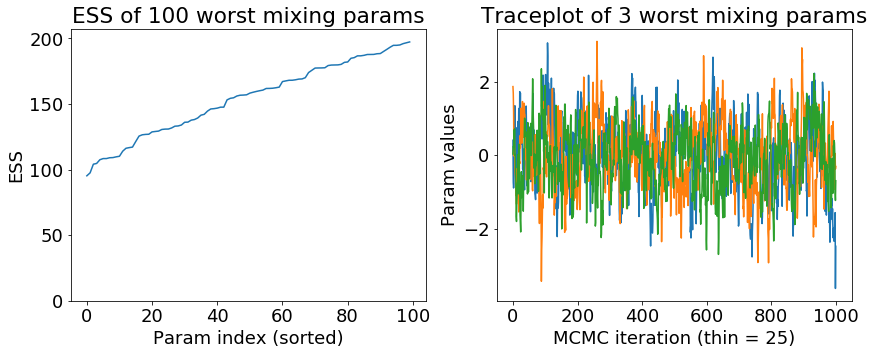

In [13]:
plt.figure(figsize=(14, 5))
plt.rcParams['font.size'] = 18

plt.subplot(1, 2, 1)
plt.plot(ess_gibbs[index_sort[:100]])
plt.ylabel('ESS')
plt.xlabel('Param index (sorted)')
plt.title('ESS of 100 worst mixing params')
plt.ylim(0, 1.05 * np.max(ess_gibbs[index_sort[:100]]))

plt.subplot(1, 2, 2)
thin = 25
plt.plot(gibbs_samples[::thin, index_sort[:3]])
plt.ylabel('Param values')
plt.xlabel('MCMC iteration (thin = {:d})'.format(thin))
plt.title('Traceplot of 3 worst mixing params')

plt.show()